# Homework 6 - Generative Adversarial Network
This is the sample code for hw6 of 2022 Machine Learning course in National Taiwan University. 

In this sample code, there are 5 sections:
1. Environment setting
2. Dataset preparation
3. Model setting
4. Train
5. Inference

Your goal is to do anime face generation, if you have any question, please discuss at NTU COOL 

# Environment setting
In this section, we will prepare for the dataset and set some environment variable

In [ ]:
!nvidia-smi

Tue Apr 12 03:58:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download Dataset

In [ ]:
# get dataset from huggingface hub
%%capture
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | bash
!apt-get install git-lfs
!git lfs install
!git clone https://huggingface.co/datasets/LeoFeng/MLHW_6
!unzip ./MLHW_6/faces.zip -d .

In [ ]:
%%capture
!pip install stylegan2_pytorch
!pip install Pillow==9.0.0

## Other setting

In [ ]:
# import module
import os
import glob
import random
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import logging
from tqdm import tqdm


# seed setting
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2022)
workspace_dir = '.'

# Dataset preparation
In this section, we prepare for the dataset for Pytorch

## Create dataset for Pytorch

In order to unified image information, we use the transform function to:
1. Resize image to 64x64
2. Normalize the image

This CrypkoDataset class will be use in Section 4

In [ ]:
# prepare for CrypkoDataset

class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = torchvision.io.read_image(fname)
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples

def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

## Show the image
Show some sample in the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


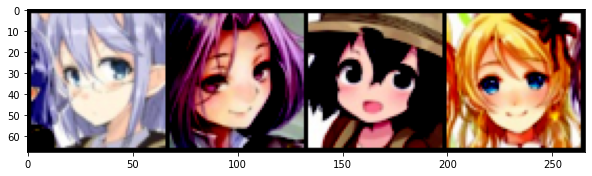

In [ ]:
temp_dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [temp_dataset[i] for i in range(4)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

# Train model
https://github.com/lucidrains/stylegan2-pytorch

In [ ]:
!stylegan2_pytorch --data /content/faces --num-train-steps 20000 --image-size 64

default</content/faces>:   0% 50/20000 [00:51<5:39:28,  1.02s/it]G: 19.20 | D: 1.83 | GP: 0.17
default</content/faces>:   0% 100/20000 [01:38<5:26:36,  1.02it/s]G: -0.67 | D: 1.70 | GP: 0.08
default</content/faces>:   1% 150/20000 [02:27<5:24:19,  1.02it/s]G: 0.20 | D: 2.99 | GP: 2.22
default</content/faces>:   1% 200/20000 [03:13<5:19:57,  1.03it/s]G: 12.59 | D: 1.20 | GP: 12.11
default</content/faces>:   1% 250/20000 [04:02<5:19:25,  1.03it/s]G: -0.18 | D: 1.13 | GP: 25.95
default</content/faces>:   2% 300/20000 [04:49<5:16:50,  1.04it/s]G: 3.57 | D: 1.26 | GP: 1.91
default</content/faces>:   2% 350/20000 [05:38<5:16:40,  1.03it/s]G: 1.13 | D: 1.09 | GP: 2.61
default</content/faces>:   2% 400/20000 [06:25<5:15:12,  1.04it/s]G: 1.93 | D: 1.12 | GP: 36.83
default</content/faces>:   2% 450/20000 [07:15<5:15:15,  1.03it/s]G: 1.14 | D: 0.80 | GP: 852.29
default</content/faces>:   2% 500/20000 [08:03<5:14:14,  1.03it/s]G: 3.66 | D: 0.70 | GP: 1.94
default</content/faces>:   3% 550/20000 [0

In [ ]:
!stylegan2_pytorch --generate-interpolation --models_dir /content/models/default --interpolation-num-steps 5

100% 5/5 [00:05<00:00,  1.12s/it]
interpolation generated at ./results/default/generated-04-12-2022_09-43-08


continuing from previous epoch - 20
loading from version 1.8.8


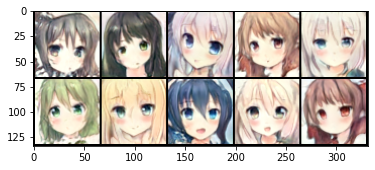

In [15]:
import torch
from torchvision.utils import save_image
from stylegan2_pytorch import ModelLoader

loader = ModelLoader(
    base_dir = '/content',   # path to where you invoked the command line tool
    name = 'default'                             # the project name, defaults to 'default'
)

n_output = 1000
noise   = torch.randn(n_output, 512) # noise
styles  = loader.noise_to_styles(noise, trunc_psi = 0.7)  # pass through mapping network

imgs_sample = loader.styles_to_images(styles[:10])
grid_img = torchvision.utils.make_grid(imgs_sample.cpu(), nrow=5)
plt.figure()
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Inference through trainer
**You should restart the session, or `save_image` might not work**

In [20]:
count = 0
os.makedirs('output', exist_ok=True)
for i in range(100):
    images = loader.styles_to_images(styles[i*10:(i+1)*10])
    for a_img in images:
        save_image(a_img, f'output/{count+1}.jpg') # save your images, or do whatever you desire
        count += 1

## Prepare .tar file for submission

In [17]:
# Compress the images.
%cd output
!tar -zcf ../submission.tgz *.jpg
%cd ..

/content/output
/content


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>